In [333]:
library(ggplot2)
library(gridExtra)
library(grid)
library(data.table)
source("../ores_bias_project/helper.R")

In [325]:
theme_set(theme_bw())

In [241]:
dt.all = fread("../ores_bias_project/ores_bias_data/cutoff_revisions.csv")

Warning message in fread("../ores_bias_project/ores_bias_data/cutoff_revisions.csv"):
“Found and resolved improper quoting out-of-sample. First healed line 3988: <<enwiki,2017-04-16 05:31:46.0,20950263,"12\"/50_caliber_Mark_8_gun",,,false,false,775642167,true,anonymous,,huggle,3998,2017-04-13T18:41:00.000Z,2017-05-11T18:41:00.000Z,2017-04-27T18:41:00.000Z,true>>. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”

In [242]:
dt = dt.all[time_to_revert < 60*60*24*30]

In [243]:
dt = dt[revert_tool != 'twinkle']

In [244]:
cutoffs = fread("../ores_bias_project/ores_bias_data/ores_rcfilters_cutoffs.csv")

In [245]:
cutoffs[wiki_db=='fawiki']

wiki_db,commitsha,has_ores,has_rcfilters,has_rcfilters_watchlist,commit_dt,deploy_dt,deploy_gap
fawiki,83721dc27d3ecadb550a759e9004c794ad0cb792,TRUE,FALSE,FALSE,2016-06-22 08:08:26,2016-06-22 15:13:00,0 days 07:04:34.000000000
fawiki,653ef7704f549485c006186a7f77c92a06435717,TRUE,TRUE,FALSE,2017-04-11 06:38:06,2017-04-11 11:09:00,0 days 04:30:54.000000000
fawiki,c7fcbedb5ce048d3b3bac1d1b1bb1699b308c5e0,FALSE,FALSE,TRUE,2017-12-09 03:10:52,2017-12-09 11:19:00,0 days 08:08:08.000000000
fawiki,a02677f8990f2340b22f2e15d0dc23bdb0903a31,TRUE,TRUE,TRUE,2017-12-11 16:27:39,2017-12-11 18:56:00,0 days 02:28:21.000000000


In [246]:
cutoffs <- cutoffs[order(cutoffs$deploy_dt)]

In [247]:
cutoffs$deploy_dt <- parse_date_iso(cutoffs$deploy_dt)

In [248]:
cutoffs[wiki_db == 'fawiki']

wiki_db,commitsha,has_ores,has_rcfilters,has_rcfilters_watchlist,commit_dt,deploy_dt,deploy_gap
fawiki,83721dc27d3ecadb550a759e9004c794ad0cb792,TRUE,FALSE,FALSE,2016-06-22 08:08:26,2016-06-22 15:13:00,0 days 07:04:34.000000000
fawiki,653ef7704f549485c006186a7f77c92a06435717,TRUE,TRUE,FALSE,2017-04-11 06:38:06,2017-04-11 11:09:00,0 days 04:30:54.000000000
fawiki,c7fcbedb5ce048d3b3bac1d1b1bb1699b308c5e0,FALSE,FALSE,TRUE,2017-12-09 03:10:52,2017-12-09 11:19:00,0 days 08:08:08.000000000
fawiki,a02677f8990f2340b22f2e15d0dc23bdb0903a31,TRUE,TRUE,TRUE,2017-12-11 16:27:39,2017-12-11 18:56:00,0 days 02:28:21.000000000


In [249]:
dt$date <- parse_date_tz(dt$date)
cutoffs$deploy_dt <- parse_date_iso(cutoffs$deploy_dt)

In [250]:
#handle special cases
# fa wiki had a bug that we can ignroe
cutoffs <- cutoffs[!((wiki_db == 'fawiki') & ( (deploy_dt == parse_date_iso("2017-12-09 11:19:00"))  | (deploy_dt == parse_date_iso("2017-12-11 18:56:00"))))]

In [251]:
cutoffs[wiki_db == 'fawiki']

wiki_db,commitsha,has_ores,has_rcfilters,has_rcfilters_watchlist,commit_dt,deploy_dt,deploy_gap
fawiki,83721dc27d3ecadb550a759e9004c794ad0cb792,TRUE,FALSE,FALSE,2016-06-22 08:08:26,2016-06-22 15:13:00,0 days 07:04:34.000000000
fawiki,653ef7704f549485c006186a7f77c92a06435717,TRUE,TRUE,FALSE,2017-04-11 06:38:06,2017-04-11 11:09:00,0 days 04:30:54.000000000


In [252]:
#frwiki and ruwiki had a bug that we can ignore
cutoffs <- cutoffs[!((wiki_db=='frwiki') & (deploy_dt >= parse_date_iso("2017-11-09 14:35:00")))]
                                                
cutoffs <- cutoffs[!((wiki_db=='ruwiki') & (deploy_dt >= parse_date_iso("2017-11-20 19:22:00")))]

# kowiki's two commits have the same deploy time
cutoffs <- cutoffs[!((wiki_db == 'kowiki') & (commit_dt == parse_date_iso("2019-03-04 11:26:06")))]

In [253]:
cutoffs <- cutoffs[,.(commitsha = first(commitsha),
                      has_ores = any(has_ores),
                      has_rcfilters = any(has_rcfilters), 
                      has_rcfilters_watchlist = any(has_rcfilters_watchlist), 
                      commit_dt = last(commit_dt),
                      deploy_gap = last(deploy_gap)),
                   by=c('wiki_db','deploy_dt')]

In [254]:
dt <- merge(dt, cutoffs, by.x=c("wiki_db","date"), by.y=c("wiki_db",'deploy_dt'),all.x=T)

In [255]:
## rename some variables
dt <- dt[pre_cutoff == T, pre_cutoff_1 := 'Before design change']
dt <- dt[pre_cutoff == F, pre_cutoff_1 := 'After design change']

In [256]:
dt <- dt[,time_to_revert := time_to_revert]

In [257]:
dt <- dt[, pre_cutoff_1 := factor(pre_cutoff_1, levels = c("Before design change", "After design change"))]

In [258]:
dt [ (event_user_isbot1 | event_user_isbot2) & revision_is_identity_reverted, revert_tool := 'bot']

In [259]:
ores_cutoffs <- cutoffs[,.(date=first(.SD[has_ores==T]$deploy_dt)),by=c("wiki_db")]

In [260]:
ores_sample <- dt[ores_cutoffs,.SD,on=c('date','wiki_db')]

In [261]:
duration_x_names <- c('1 second','5 seconds','1 minute','5 minutes','1 hour','24 hours','1 week','1 month')
duration_x_values <- c(1,5,60,60*5,60*60,60*60*24, 60*60*24*7, 60*60*24*30)

In [262]:
p <- ggplot(ores_sample, aes(x=time_to_revert,group=revert_tool,color=revert_tool, y=..count..)) + geom_density() + facet_grid(wiki_db~pre_cutoff_1, scales='free_y') + scale_x_log10(breaks=duration_x_values,labels=duration_x_names) + theme(axis.text.x = element_text(angle=90),legend.position='top')

In [263]:
ggsave('../ores_bias_plots/time_to_revert_by_tool_ores_cuttoff.pdf', p,width=14, height=300, units='cm',limitsize=F)

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 31 rows containing non-finite values (stat_density).”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”

In [264]:
enwiki_ores_cutoff <- first(cutoffs[(wiki_db == 'enwiki') & (has_ores=T)]$deploy_dt)

In [265]:
enwiki_ores_sample <- dt[ (wiki_db == 'enwiki') & (date == enwiki_ores_cutoff)]

In [266]:
enwiki_ores_sample_reverts <- enwiki_ores_sample[revision_is_identity_reverted == T]

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 11 rows containing non-finite values (stat_density).”

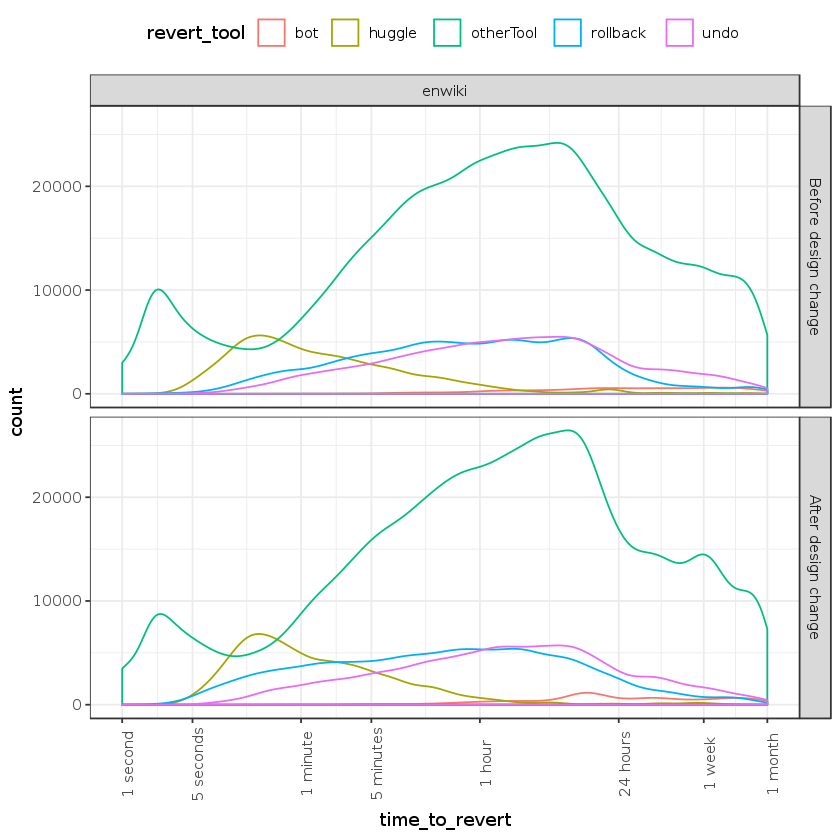

In [267]:
ggplot(enwiki_ores_sample_reverts, aes(x=time_to_revert,group=revert_tool,color=revert_tool, y=..count..)) + geom_density() + facet_grid(pre_cutoff_1~wiki_db) + scale_x_log10(breaks=duration_x_values,labels=duration_x_names) + theme(axis.text.x = element_text(angle=90), legend.position='top')

In [268]:
watchlist_cutoffs <- cutoffs[,.(date=first(.SD[has_rcfilters_watchlist==T]$deploy_dt)),by=c("wiki_db")]

In [269]:
watchlist_sample <- dt[watchlist_cutoffs,.SD,on=c('date','wiki_db')]

In [270]:
watchlist_cutoffs[wiki_db =='fawiki']

wiki_db,date


In [271]:
dt[ (wiki_db=='fawiki') & (event_timestamp > watchlist_cutoffs[wiki_db=='fawiki']$date)]

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”

wiki_db,date,event_timestamp,page_id,page_title,user_id,user_text,event_user_isbot1,event_user_isbot2,revision_id,⋯,period_start,period_end,pre_cutoff,commitsha,has_ores,has_rcfilters,has_rcfilters_watchlist,commit_dt,deploy_gap,pre_cutoff_1


In [272]:
p <- ggplot(watchlist_sample, aes(x=time_to_revert,group=revert_tool,color=revert_tool,y=..count..)) + geom_density() + facet_grid(wiki_db~pre_cutoff_1, scales='free_y') + scale_x_log10(breaks=duration_x_values,labels=duration_x_names) + theme(axis.text.x = element_text(angle=90), legend.position='top')

In [273]:
ggsave("../ores_bias_plots/time_to_revert_by_tool_watchlist_cuttoff.pdf",p,width=14,height=300,units='cm',limitsize=F)

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 26 rows containing non-finite values (stat_density).”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”

In [274]:
enwiki_watchlist_cutoff <- first(cutoffs[(wiki_db == 'enwiki') & (has_rcfilters_watchlist == T)]$deploy_dt)

In [275]:
enwiki_watchlist_sample <- dt[ (wiki_db == 'enwiki') & (date == enwiki_watchlist_cutoff)]

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 9 rows containing non-finite values (stat_density).”

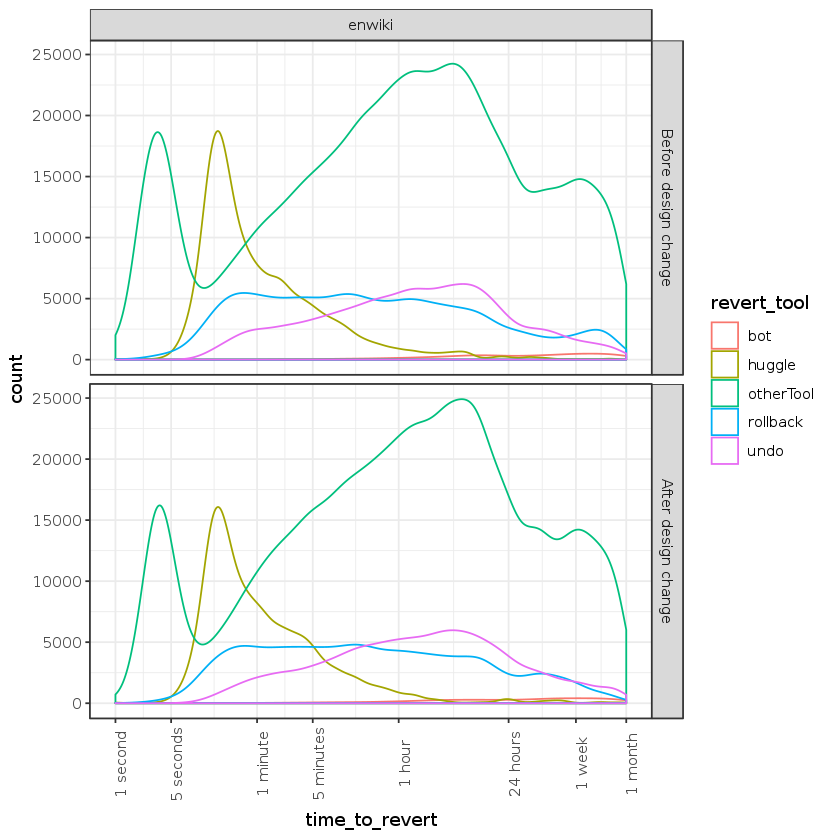

In [276]:
ggplot(enwiki_watchlist_sample, aes(x=time_to_revert,group=revert_tool,color=revert_tool,y=..count..)) + geom_density() + facet_grid(pre_cutoff_1~wiki_db)  + scale_x_log10(breaks=duration_x_values,labels=duration_x_names) + theme(axis.text.x = element_text(angle=90))

In [277]:
sample <- watchlist_sample
wiki <- 'enwiki'
x <- 'time_to_revert'
group <- 'revert_tool'
y <- "..count.."
breaks <- duration_x_values
labels <- duration_x_names
facet_row <- 'pre_cutoff_1'
facet_col <- 'revert_tool'
bins <- 100

In [278]:
wikis <- unique(sample$wiki_db)
tools <- unique(sample$revert_tool)[2:6]

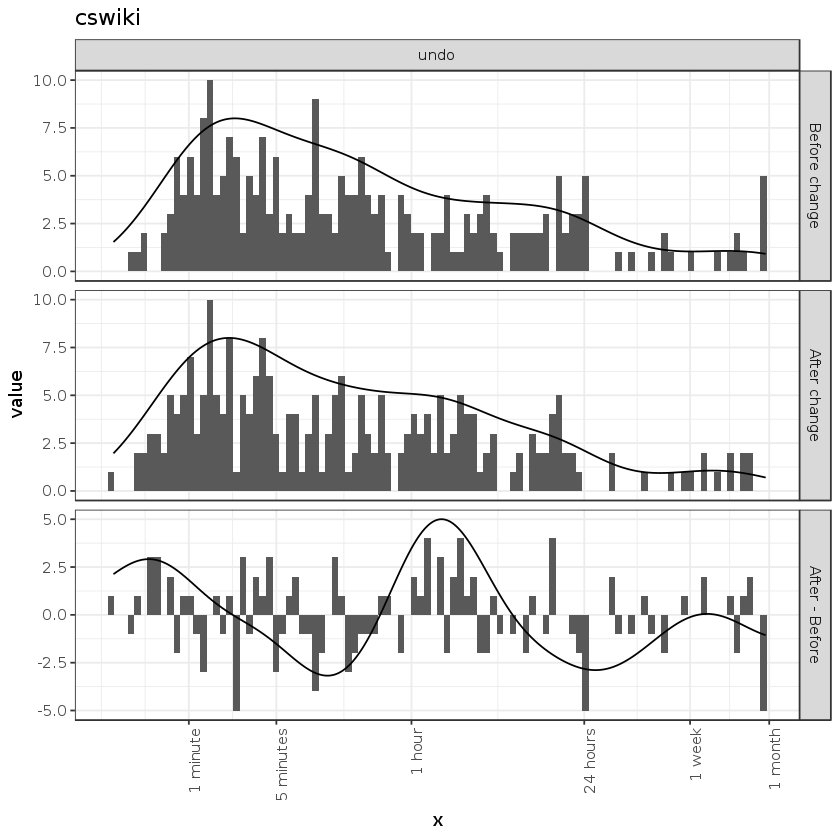

In [340]:
tool <- 'undo'
wiki <- 'cswiki'
ttr_grid_plot(sample,wiki,tool,100)

In [200]:
# aliasing might be misleading so we can do it again using kernels: ..density..

In [341]:
hist_plots <- list()
density_plots <- list()
combined.plots <- list()
i <- 1
for(wiki in wikis){
    for(tool in tools){
        hist_plots[[i]] <- ttr_histogram_plot(sample,wiki,tool)
        density_plots[[i]] <- ttr_density_plot(sample,wiki,tool)
        combined.plots[[i]] <- ttr_grid_plot(sample,wiki,tool)
        i <- i + 1
    }
}

Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Transformation introduced infinite values in continuous x-axis”Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Transformation introduced infinite value

In [342]:
hist_p <- marrangeGrob(grobs=hist_plots,nrow=1,ncol=length(tools))

In [343]:
dens_p <- marrangeGrob(grobs=density_plots,nrow=1,ncol=length(tools))

In [344]:
combin_p <- marrangeGrob(grobs=combined.plots, nrow=1, ncol=length(tools))

In [345]:
ggsave('../ores_bias_plots/time_to_revert_hist_grid.pdf',width=12,height=8,plot=hist_p)
ggsave('../ores_bias_plots/time_to_revert_density_grid.pdf',width=12,height=8,plot=dens_p)

In [346]:
ggsave('../ores_bias_plots/time_to_revert_grid.pdf',width=12,height=8,plot=combin_p)

In [147]:
wikis <- unique(dt$wiki_db)
tools <- unique(dt$revert_tool)
n.wikis <- length(wikis)
n.tools <- length(tools)

watchlist.utest.grid <- data.table(expand.grid(wiki=wikis,tool=tools),median.pre=NaN, median.post = NaN,U.p.value =NaN,mean.pre=NaN, mean.post=NaN, T.p.value=NaN)



In [149]:
i <- 1
for(iwiki in wikis){
    for(itool in tools){
        data.pre <- watchlist_sample[(wiki_db==iwiki) & (revert_tool==itool) & (pre_cutoff==TRUE)]$time_to_revert
        data.post <- watchlist_sample[(wiki_db==iwiki) & (revert_tool==itool) & (pre_cutoff==FALSE)]$time_to_revert

        # the hypothesis is that time to reverts will decrease for undo, but may increase or decrease for rollback
        alt='two.sided'

        if(tool == 'undo'){
            alt = 'greater'
        }
        if(tool == 'rollback'){
            alt= 'less'
        }
        if( (length(data.pre) > 1) & (length(data.post) > 1)){
            UT <- wilcox.test(data.pre, data.post, correct=T, alternative=alt)
            TT <- t.test(data.pre, data.post, alternative=alt)
            watchlist.utest.grid[(wiki==iwiki) & (tool==itool),
                                 ":="(
                                     median.pre=median(data.pre),
                                     median.post=median(data.post),
                                     U.p.value = UT$p.value,
                                     mean.pre = mean(data.pre),
                                     mean.post = mean(data.post),
                                     T.p.value = TT$p.value
                                 )
                                ]
        } 
    }
}

Warning message in wilcox.test.default(data.pre, data.post, correct = T, alternative = alt):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(data.pre, data.post, correct = T, alternative = alt):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(data.pre, data.post, correct = T, alternative = alt):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(data.pre, data.post, correct = T, alternative = alt):
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(data.pre, data.post, correct = T, alternative = alt):
“cannot compute exact p-value with ties”

In [150]:
watchlist.utest.grid[tool=='rollback']

wiki,tool,median.pre,median.post,U.p.value,mean.pre,mean.post,T.p.value
arwiki,rollback,3955.0,7577.0,2.633523e-08,74844.015,74181.610,9.365032e-01
bswiki,rollback,NaN,NaN,NaN,NaN,NaN,NaN
cawiki,rollback,1359.0,1306.0,6.020255e-01,17210.634,11664.374,2.123735e-01
cswiki,rollback,124.0,108.0,4.467042e-01,9794.161,11208.164,7.802427e-01
enwiki,rollback,1297.0,1258.0,6.106265e-02,105420.049,66020.954,7.848536e-47
eswiki,rollback,39.0,36.0,1.411656e-10,16125.340,17514.010,1.970185e-01
eswikibooks,rollback,3631.0,9558.0,6.355431e-03,12483.863,28405.133,2.185825e-02
eswikiquote,rollback,10818.0,9145.5,9.331779e-01,16443.500,11554.050,3.212021e-01
etwiki,rollback,776.0,682.5,5.293096e-02,77737.715,5303.789,1.206638e-03
euwiki,rollback,10486.5,2347.0,6.725371e-02,9765.643,2347.000,1.505360e-01


In [151]:
watchlist.utest.grid[tool=='undo']

wiki,tool,median.pre,median.post,U.p.value,mean.pre,mean.post,T.p.value
arwiki,undo,1251.0,1549.0,6.802405e-01,83421.46,138363.6610,3.537932e-01
bswiki,undo,11195.0,5735.0,6.811144e-01,38102.42,151030.4731,1.649548e-02
cawiki,undo,2446.5,8982.0,1.750102e-03,83472.21,158726.1238,5.283574e-02
cswiki,undo,668.0,678.0,5.572224e-01,91801.71,65358.3237,3.711108e-01
enwiki,undo,6221.0,7160.0,7.055017e-07,91240.67,106049.9882,3.473833e-06
eswiki,undo,6450.0,6540.0,5.581020e-01,126190.52,128887.9283,7.661086e-01
eswikibooks,undo,349.0,10767.0,1.904762e-01,1989.00,57392.6000,3.328591e-01
eswikiquote,undo,5983.0,9205.5,1.962799e-01,45621.07,53159.4000,8.516291e-01
etwiki,undo,1342.0,2309.0,4.294128e-01,67988.35,126873.5806,5.315485e-01
euwiki,undo,12899.0,5355.0,9.147826e-01,15358.75,5840.6667,3.666807e-01


In [152]:
watchlist.utest.grid[wiki == 'enwiki']

wiki,tool,median.pre,median.post,U.p.value,mean.pre,mean.post,T.p.value
enwiki,undo,6221,7160,7.055017e-07,91240.675,106049.988,3.473833e-06
enwiki,otherTool,4428,5321,5.746767e-27,154987.888,154857.072,9.433415e-01
enwiki,rollback,1297,1258,6.106265e-02,105420.049,66020.954,7.848536e-47
enwiki,bot,167213,128575,2.204091e-02,516785.337,464721.398,6.939289e-02
enwiki,huggle,38,43,8.484045e-06,4569.639,6586.097,1.129462e-02


In [155]:
watchlist.deltas <- dt[has_rcfilters_watchlist.y == T,.(p_reverted = mean(revision_is_identity_reverted),
                                                        p_undo = mean(revert_tool == 'undo'),
                                                        p_rollback = mean(revert_tool == 'rollback'),
                                                        p_bot = mean(revert_tool == 'bot'), 
                                                        p_huggle = mean(revert_tool == 'huggle'), 
                                                        p_other = mean(revert_tool == 'other'),
                                                        n_edits_in_subperiod = .N
                                                       ), by=.(wiki_db, pre_cutoff, date)]

ERROR: Error in .checkTypos(e, names(x)): Object 'has_rcfilters_watchlist.y' not found. Perhaps you intended has_rcfilters_watchlist
